Column Definitions - Column information from kaggle dataset (https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv), Columns with asterisks are defined by statcast definitions found at https://baseballsavant.mlb.com/csv-docs. Some definitions modified for clarity by me. Additional clarity can be found at https://trackman.zendesk.com/hc/en-us/articles/115002776647-Radar-Measurement-Glossary-of-Terms and https://fastballs.wordpress.com/category/pitchfx-glossary/

1. px: x-location as pitch crosses the plate. X=0 means right down the middle
2. pz: z-location as pitch crosses the plate. Z=0 means the ground
3. start_speed: Speed of the pitch upon release by the pitcher (as it's thrown)
4. end_speed: Speed of the pitch when it crosses the front edge of the plate
5. spin_rate: The pitch's spin rate, measure in RPM
6. spin_dir: Direction in which pitch is spinning, measured in degrees (assuming 0 is the vector directly between the center of the mound and the center of home plate).
7. *break_angle: (None, deprecated from pre-statcast system, assuming 0 is vertical, angle of vector over break) 
8. *break_length: (None, deprecated from pre-statcast system, magnitude of break vector)
9. *break_y:
10. *ax: The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
11. *ay: The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.
12. *az: The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.
13. *sz_bot: Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
14. *sz_top: Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
15. type_confidence: Confidence in pitch_type classification. Goes up to 2 for some reason.
16. *vx0: The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet.
17. *vy0: The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet.
18. *vz0: The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet.
19. x
20. x0: the left/right distance, in feet, of the pitch, measured at the initial point.
21. y
22. *y0: the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters. This parameter has been variously set at 40, 50, or 55 feet (and in a few instances 45 feet) from the plate at different times throughout the 2007 season as Sportvision experiments with optimal settings for the PITCHf/x measurements. Sportvision settled on 50 feet in the second half of 2007, and this value of y0=50 feet has been used since. Changes in this parameter impact the values of all other parameters measured at the release point, such as start_speed.
23. *z0:  the height, in feet, of the pitch, measured at the initial point.
24. *pfx_x: Horizontal movement in feet from the catcher's perspective.
25. *pfx_z: Vertical movement in feet from the catcher's perspective.
26. nasty
27. *zone: Zone location of the ball when it crosses the plate from the catcher's perspective. 1-9 are in zone, left to right, then high to low. 11 is up and left of the zone, 12 is up and right of the zone, 13 and 14 are same for low
28. code: Records the result of the pitch. See dataset description for list of codes and their meaning
29. type: Simplified code, S (strike) B (ball) or X (in play)
30. pitch_type: Type of pitch. See dataset description for list of pitch types
31. event_num: event number, used for finding when exactly ejections happen.
32. b_score: score for the batter's team
33. ab_id: at-bat ID. Matches up with atbats.csv
34. b_count: balls in the current count
35. s_count: strikes in the current count
36. outsnumber of outs (before pitch is thrown)
37. pitch_num: pitch number (of at-bat)
38. on_1b: True if there's a runner on first, False if empty
39. on_2b: True if there's a runner on second, False if empty
40. on_3b: I don't know (/s. True if there's a runner on third, False if empty)

In [1]:
# Import required packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

pitches = pd.read_csv('/Users/JKovach/Downloads/mlb-pitch-data-20152018/pitches.csv')

# Reduce length by factor of 10 to increase performance, nan < 1% of values, drop nan
pitch_sample = pitches.sample(frac=.001, replace=True, random_state=0)
pitch_sample = pitch_sample.dropna(how='any')

# Numerical encoding for string type variables
num = LabelEncoder()
pitch_sample['n_pitch_type'] = num.fit_transform(pitch_sample['pitch_type'].astype('str'))
pitch_sample['n_type'] = num.fit_transform(pitch_sample['type'].astype('str'))
pitch_sample['n_code'] = num.fit_transform(pitch_sample['code'].astype('str'))

# Drop variables which we encoded in previous function, 
# Drop y0 since it has zero variance (y0=50 by definition)
pitch_sample = pitch_sample.drop(['pitch_type', 'type', 'code', 'y0'], 1)

pitch_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845 entries, 305711 to 722496
Data columns (total 39 columns):
px                 2845 non-null float64
pz                 2845 non-null float64
start_speed        2845 non-null float64
end_speed          2845 non-null float64
spin_rate          2845 non-null float64
spin_dir           2845 non-null float64
break_angle        2845 non-null float64
break_length       2845 non-null float64
break_y            2845 non-null float64
ax                 2845 non-null float64
ay                 2845 non-null float64
az                 2845 non-null float64
sz_bot             2845 non-null float64
sz_top             2845 non-null float64
type_confidence    2845 non-null float64
vx0                2845 non-null float64
vy0                2845 non-null float64
vz0                2845 non-null float64
x                  2845 non-null float64
x0                 2845 non-null float64
y                  2845 non-null float64
z0                 2845 n

In [2]:
# Gaussian NB for Model #1
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

y = pitch_sample['zone']
X = pitch_sample.drop(['zone'],1)

# Check class imbalance
print("Class Balance: {}".format(sorted(Counter(y).items())))

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

Class Balance: [(1.0, 97), (2.0, 88), (3.0, 79), (4.0, 135), (5.0, 171), (6.0, 142), (7.0, 131), (8.0, 131), (9.0, 131), (11.0, 396), (12.0, 254), (13.0, 463), (14.0, 627)]
Number of mislabeled points out of 2845: 1462
Accuracy Rate: 0.48611599297012303


array([[  0,   0,   0,   0,   1,   0,   0,   0,   0,  66,   0,  14,  16],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,  54,   5,   1,  26],
       [  0,   0,   0,   0,   1,   1,   0,   0,   0,  26,  25,   0,  26],
       [  0,   0,   0,   0,   7,   0,   0,   0,   0,  75,   0,  34,  19],
       [  0,   0,   0,   0,  23,   2,   0,   0,   0,  69,   1,   9,  67],
       [  0,   0,   0,   0,   5,   7,   0,   0,   0,  25,  21,   1,  83],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,  38,   1,  71,  20],
       [  0,   0,   0,   0,   4,   2,   0,   0,   0,  23,   0,  28,  74],
       [  0,   0,   0,   0,   0,   9,   0,   0,   0,   5,   0,   3, 114],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 328,   5,  50,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  38, 128,   0,  88],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  94,   2, 313,  54],
       [  0,   0,   0,   0,   0,   0,   3,   0,   0,   1,  26,  14, 583]])

In [3]:
pitch_sz = pitch_sample[pitch_sample['zone']<10]

y = pitch_sz['zone']
X = pitch_sz.drop(['zone'],1)

# Check class imbalance
print(sorted(Counter(y).items()))

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

[(1.0, 97), (2.0, 88), (3.0, 79), (4.0, 135), (5.0, 171), (6.0, 142), (7.0, 131), (8.0, 131), (9.0, 131)]
Number of mislabeled points out of 1105: 710
Accuracy Rate: 0.3574660633484163


array([[10,  5,  0, 46, 21,  0,  6,  6,  3],
       [ 0,  7,  2,  8, 39, 27,  1,  1,  3],
       [ 0,  0,  8,  0, 18, 48,  0,  0,  5],
       [ 1,  1,  0, 57, 38,  2, 19, 11,  6],
       [ 0,  0,  0, 15, 99, 31,  3, 13, 10],
       [ 0,  0,  0,  0, 38, 84,  1,  6, 13],
       [ 0,  0,  0, 32, 16,  1, 57, 19,  6],
       [ 0,  0,  0,  6, 39, 23, 23, 23, 17],
       [ 0,  0,  0,  0, 17, 54,  3,  7, 50]])

In [4]:
from imblearn.over_sampling import RandomOverSampler

y = pitch_sample['zone']
X = pitch_sample.drop(['zone'],1)

# Create random oversampling of data
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)

# Check class imbalance
print(sorted(Counter(y_rs).items()))

gnb = GaussianNB()
gnb.fit(X_rs, y_rs)
yrs_pred = gnb.predict(X_rs)

print('Number of mislabeled points out of {}: {}'.format(
    X_rs.shape[0],
    (y_rs != yrs_pred).sum()
))
print('Accuracy Rate: {}'.format((X_rs.shape[0] - (y_rs != yrs_pred).sum())/X_rs.shape[0]))

# Confusion Matrix
confusion_matrix(y_rs, yrs_pred)

[(1.0, 627), (2.0, 627), (3.0, 627), (4.0, 627), (5.0, 627), (6.0, 627), (7.0, 627), (8.0, 627), (9.0, 627), (11.0, 627), (12.0, 627), (13.0, 627), (14.0, 627)]
Number of mislabeled points out of 8151: 5180
Accuracy Rate: 0.3644951539688382


array([[150, 174,  15, 125,  49,   0,  12,  40,  13,  49,   0,   0,   0],
       [  0, 359, 141,  54,  28,   3,   7,  19,  11,   0,   0,   0,   5],
       [  0,  77, 407,   0,  17,  59,   0,   0,  54,   0,   0,   0,  13],
       [ 21,  78,   3, 288,  48,   0, 104,  63,  22,   0,   0,   0,   0],
       [  0, 127,  40, 100, 140,  67,  26,  71,  56,   0,   0,   0,   0],
       [  0,  17, 188,   0,  50, 227,   7,  44,  94,   0,   0,   0,   0],
       [  3,   9,   6, 141,  11,   0, 302, 125,  30,   0,   0,   0,   0],
       [  0,   3,  16,  61,  97,  67, 151, 143,  79,   3,   0,   0,   7],
       [  0,   0,  61,   0,  19, 205,  29,  57, 256,   0,   0,   0,   0],
       [113,  65,  28,  80,  10,   0,  15,  13,   0, 284,   6,  13,   0],
       [  0,  76, 279,   0,  17,  48,   0,   4,  41,   2, 107,   0,  53],
       [ 20,   2,   1,  91,   5,   2, 250,  89,  17,  40,   2, 105,   3],
       [  1,   2,  50,   3,   4, 117,  32,  44, 155,   1,  15,   0, 203]])

In [5]:
# Early models had extreme increase in accuracy. To identify root cause, I decided to drop each column,
# one at a time and see what our accuracy rate is.
drop = []

for var in list(pitch_sample.columns):
    print("Dropping: " + var)
    
    y = pitch_sample['zone']
    X = pitch_sample.drop(['zone', var],1)
    ros = RandomOverSampler(random_state=0)
    X_rs, y_rs = ros.fit_resample(X,y)

    gnb = GaussianNB()
    gnb.fit(X_rs, y_rs)
    yrs_pred = gnb.predict(X_rs)

    print('Number of mislabeled points out of {}: {}'.format(X_rs.shape[0], (y_rs != yrs_pred).sum()))
    print('Accuracy Rate: {}'.format((X_rs.shape[0] - (y_rs != yrs_pred).sum())/X_rs.shape[0]))
    
    # If dropping this variable produces a higher error rate, add the variable to a drop function
    if (y_rs != yrs_pred).sum() > 5180:
        drop.append(var)

print(drop)

Dropping: px
Number of mislabeled points out of 8151: 5180
Accuracy Rate: 0.3644951539688382
Dropping: pz
Number of mislabeled points out of 8151: 5180
Accuracy Rate: 0.3644951539688382
Dropping: start_speed
Number of mislabeled points out of 8151: 5199
Accuracy Rate: 0.36216415163783583
Dropping: end_speed
Number of mislabeled points out of 8151: 5204
Accuracy Rate: 0.3615507299717826
Dropping: spin_rate
Number of mislabeled points out of 8151: 5050
Accuracy Rate: 0.38044411728622257
Dropping: spin_dir
Number of mislabeled points out of 8151: 5114
Accuracy Rate: 0.372592319960741
Dropping: break_angle
Number of mislabeled points out of 8151: 5196
Accuracy Rate: 0.36253220463746777
Dropping: break_length
Number of mislabeled points out of 8151: 5190
Accuracy Rate: 0.3632683106367317
Dropping: break_y
Number of mislabeled points out of 8151: 5180
Accuracy Rate: 0.3644951539688382
Dropping: ax
Number of mislabeled points out of 8151: 5186
Accuracy Rate: 0.3637590479695743
Dropping: ay
Nu

In [6]:
# Test 1: what happens when dropping variables collected in the previous cell
drop_pitch = pitch_sample.drop(['ab_id', 'start_speed', 'end_speed', 'break_angle', 'break_length', 'ax', 
                                'ay', 'vx0', 'vy0', 'vz0', 'x', 'y', 'pfx_x', 'pfx_z', 'nasty', 'n_pitch_type', 
                                'n_code'], 1)

y = drop_pitch['zone']
X = drop_pitch.drop(['zone'],1)

# Create random oversampling of data
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)

gnb = GaussianNB()
gnb.fit(X_rs, y_rs)
yrs_pred = gnb.predict(X_rs)

print('Number of mislabeled points out of {}: {}'.format(
    X_rs.shape[0],
    (y_rs != yrs_pred).sum()
))
print('Accuracy Rate: {}'.format((X_rs.shape[0] - (y_rs != yrs_pred).sum())/X_rs.shape[0]))

# Confusion Matrix
confusion_matrix(y_rs, yrs_pred)

Number of mislabeled points out of 8151: 1648
Accuracy Rate: 0.7978162188688505


array([[499,  24,   0,  73,   0,   0,   0,   0,   0,  31,   0,   0,   0],
       [  9, 503,  12,   8,  74,   0,   0,   0,   0,  21,   0,   0,   0],
       [  0,  26, 485,   0,   0,  50,   0,   0,   0,   0,  66,   0,   0],
       [ 39,   3,   0, 538,   0,   0,  47,   0,   0,   0,   0,   0,   0],
       [  2,  93,   9,  28, 453,  12,   3,  27,   0,   0,   0,   0,   0],
       [  0,   4,  85,   0,   6, 473,   0,   0,  46,   0,   6,   0,   7],
       [  0,   0,   0,  48,   0,   0, 548,   6,   0,   0,   0,  25,   0],
       [  0,   0,   0,   0,  31,   2,  29, 547,   7,   0,   5,   3,   3],
       [  0,   0,   0,   0,   7,  49,   0,   0, 540,   0,   0,   0,  31],
       [ 48,  15,   0,  17,   0,   0,   0,   0,   0, 505,  11,  31,   0],
       [  0,  37,  57,   0,   0,  22,   0,   0,   0,  37, 404,   0,  70],
       [  1,   0,   0,   6,   0,   0,  50,  19,   0,  53,   0, 489,   9],
       [  0,   0,   0,   0,   0,  20,   0,  13,  42,   0,  25,   8, 519]])

In [7]:
# Identify low correlation features
pcor = pitch_sample.corr()
cor_target = abs(pcor['zone'])
irrelevant_features = cor_target[cor_target<0.02]
print(irrelevant_features)

type_confidence    0.000693
vx0                0.016396
event_num          0.013046
b_score            0.004652
outs               0.009654
pitch_num          0.006083
on_1b              0.011906
Name: zone, dtype: float64


In [8]:
# Test 2: Drop features based on low correlation
drop_pitch2 = pitch_sample.drop(['ab_id', 'type_confidence', 'vx0', 'event_num', 'b_score', 'outs', 
                                 'pitch_num', 'on_1b'], 1) 

y = drop_pitch2['zone']
X = drop_pitch2.drop(['zone'],1)

# Create random oversampling of data
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)

gnb = GaussianNB()
gnb.fit(X_rs, y_rs)
yrs_pred = gnb.predict(X_rs)

print('Number of mislabeled points out of {}: {}'.format(
    X_rs.shape[0],
    (y_rs != yrs_pred).sum()
))
print('Accuracy Rate: {}'.format((X_rs.shape[0] - (y_rs != yrs_pred).sum())/X_rs.shape[0]))

# Confusion Matrix
confusion_matrix(y_rs, yrs_pred)

Number of mislabeled points out of 8151: 1756
Accuracy Rate: 0.7845663108821004


array([[491,  31,   0,  73,   8,   0,   0,   0,   0,  24,   0,   0,   0],
       [  9, 480,  28,   8,  72,   6,   0,   0,   0,  24,   0,   0,   0],
       [  0,  20, 494,   0,   0,  57,   0,   0,  18,   0,  31,   0,   7],
       [ 48,   9,   0, 503,   8,   0,  55,   0,   0,   0,   0,   4,   0],
       [  0, 101,   0,  20, 456,   9,   3,  36,   0,   0,   2,   0,   0],
       [  0,   4,  72,   0,  12, 478,   0,   0,  59,   0,   2,   0,   0],
       [  0,   0,   0,  64,   0,   0, 510,  27,   0,   6,   0,  20,   0],
       [  0,   3,   0,   0,  18,   2,  28, 564,   0,   3,   0,   0,   9],
       [  0,   0,   0,   0,   0,  61,   0,   6, 557,   0,   0,   0,   3],
       [ 53,  15,   0,  14,   1,   0,   0,   0,   0, 477,  16,  51,   0],
       [  0,  39,  59,   0,   0,   8,   0,   0,   0,  26, 420,   0,  75],
       [  1,   0,   0,   7,   0,   0,  58,  20,   0,  52,   0, 477,  12],
       [  0,   0,   0,   0,   0,   9,   0,  15,  47,   0,  57,  11, 488]])

In [9]:
print(list(pitch_sample.columns))
pitch_sample = pitch_sample.drop(['ab_id', 'type_confidence', 'vx0', 'event_num', 'b_score', 'outs', 
                                 'pitch_num', 'on_1b'], 1)
print(list(pitch_sample.columns))

['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot', 'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'n_pitch_type', 'n_type', 'n_code']
['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot', 'sz_top', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'b_count', 's_count', 'on_2b', 'on_3b', 'n_pitch_type', 'n_type', 'n_code']



For: px
Min Value = -6.32 | Max Value = 5.51
Low Range = -2.4345 | High Range = 2.4655
Number of outliers is: 22
Percentage of outliers is: 0.00773286467486819

For: pz
Min Value = -1.6943478687641298 | Max Value = 6.182
Low Range = -0.1654204833974504 | High Range = 4.652852290038471
Number of outliers is: 63
Percentage of outliers is: 0.022144112478031636

For: start_speed
Min Value = 60.1 | Max Value = 101.5
Low Range = 71.15 | High Range = 105.95000000000002
Number of outliers is: 20
Percentage of outliers is: 0.007029876977152899

For: end_speed
Min Value = 54.0 | Max Value = 93.5
Low Range = 66.30000000000001 | High Range = 96.69999999999999
Number of outliers is: 30
Percentage of outliers is: 0.01054481546572935

For: spin_rate
Min Value = 31.021 | Max Value = 3272.452
Low Range = -293.17650000000026 | High Range = 3760.3395000000005
Number of outliers is: 0
Percentage of outliers is: 0.0

For: spin_dir
Min Value = 0.45399999999999996 | Max Value = 359.905
Low Range = 1.0155000

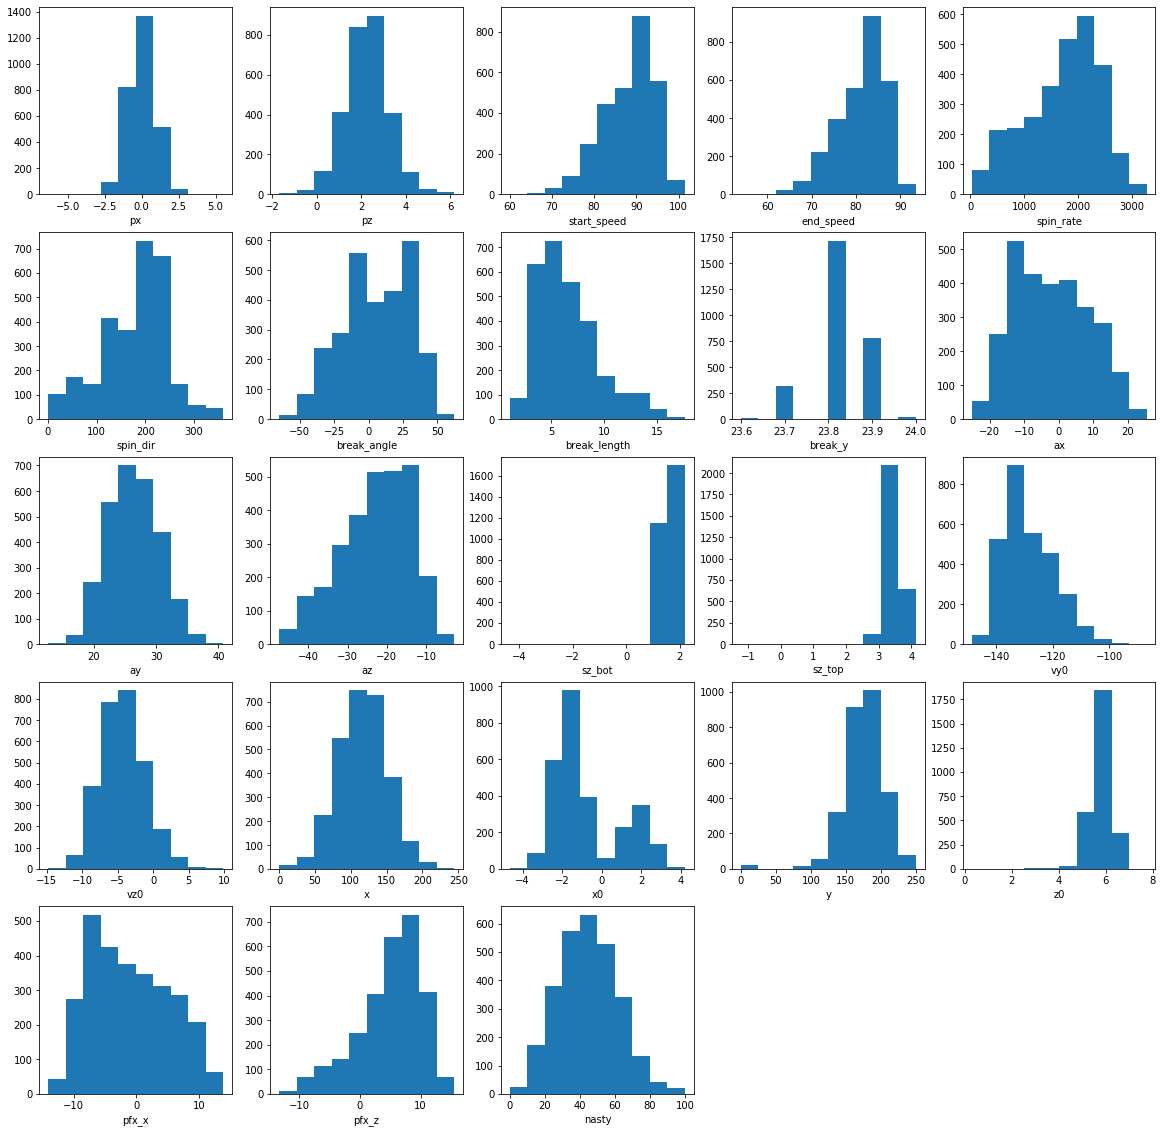

In [10]:
# split up the features which we'll treat as continuous vs categorical
cont_feat = ['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 
             'break_y', 'ax', 'ay', 'az', 'sz_bot', 'sz_top', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 
             'pfx_z', 'nasty']

# Get number of samples before outlier elimination, we'll use this later
len1 = pitch_sample.shape[0]

# Check distributions and outliers
plt.figure(figsize=(20,20))
grid = 1

for var in cont_feat:
    plt.subplot(5,5,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1
    
for var in cont_feat:   
    print("\nFor: " + var)
    q75, q25 = np.percentile(pitch_sample[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
    print("Min Value = {} | Max Value = {}".format(min(pitch_sample[var]), max(pitch_sample[var])))
    print("Low Range = {} | High Range = {}".format(min_val, max_val))
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(ol/pitch_sample.shape[0]))

For: px
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pz
Number of outliers is: 57
Percentage of outliers is: 0.020191285866099893
For: start_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: end_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_rate
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_dir
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_angle
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 59
Percentage of outliers is: 0.021238300935925127
For: break_y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ax
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ay
Number of outliers is: 0
Percentage of outliers is: 0.0
For: az
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_bot
Number of outliers is: 52
Percentage of outliers is: 0.0187929165160824
For: sz_top
Number of outliers is: 33
Percentage of outlier

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,pz,break_length,sz_bot,sz_top,y,z0,pfx_z
count,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,2.255375,6.392970,1.564373,3.435617,176.202486,5.801433,5.212004
std,0.941359,2.730195,0.183978,0.226556,28.080908,0.424448,5.022512
min,-1.015000,1.100000,-4.341143,-1.224536,0.000000,3.019000,-13.280000
25%,1.654795,4.300000,1.490000,3.303654,161.440000,5.548000,2.463962
50%,2.264513,5.900000,1.573341,3.445041,177.020000,5.820000,6.083330
75%,2.838127,7.900000,1.660000,3.580000,193.585000,6.083438,9.002314
max,5.911000,16.800000,2.196187,4.135000,249.990000,7.079000,15.480000


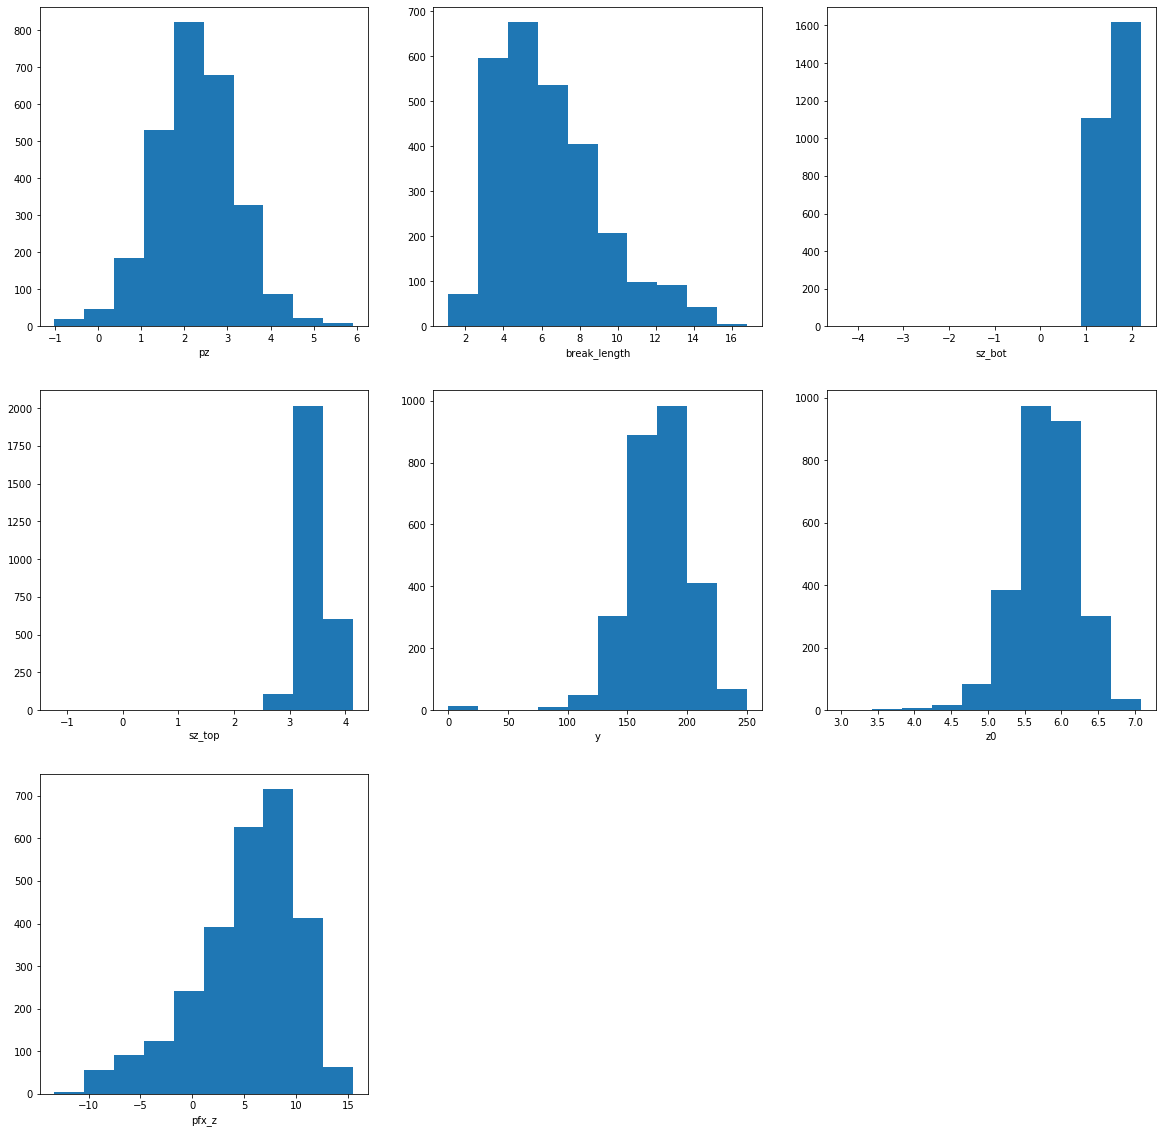

In [11]:
check = []

for var in cont_feat:
    print("For: " + var)
    q75, q25 = np.percentile(pitch_sample[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
    otl_perc = ol/pitch_sample.shape[0]
    
    # Drops outliers if variable total is less than 1%
    if otl_perc < 0.01:
        pitch_sample = pitch_sample[pitch_sample[var]<max_val]
        pitch_sample = pitch_sample[pitches[var]>min_val]
        ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
        otl_perc = ol/pitch_sample.shape[0]
    
    else:
        check.append(var)
    
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))

print("Samples after dropping outliers: {} of {}".format(pitch_sample.shape[0], len1))
    
plt.figure(figsize=(20,20))
grid = 1

for var in check:
    plt.subplot(3,3,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1

pitch_sample[check].describe()

# Some columns with more than 1% outliers are missing. I believe that the previous iterations of the loop
# dropped enough concurrent outliers to drop the percentage of outliers in these columns below 1%

In [12]:
y = pitch_sample['zone']
X = pitch_sample.drop(['zone'],1)
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

Number of mislabeled points out of 2731: 582
Accuracy Rate: 0.7868912486268766


array([[ 70,   4,   0,   8,   2,   0,   0,   0,   0,   9,   0,   0,   0],
       [  0,  65,   2,   1,  14,   0,   0,   0,   0,   4,   0,   0,   0],
       [  0,   3,  56,   0,   0,   8,   0,   0,   0,   0,   6,   0,   5],
       [  6,   2,   0, 102,   5,   0,  10,   0,   0,   1,   0,   5,   0],
       [  1,  26,   0,   6, 114,   3,   1,  14,   0,   0,   1,   0,   1],
       [  0,   1,  13,   0,   3, 109,   0,   0,  11,   0,   0,   0,   1],
       [  0,   0,   0,  13,   0,   0, 102,   8,   0,   1,   0,   5,   0],
       [  0,   1,   0,   0,   5,   1,   6, 112,   2,   1,   0,   0,   2],
       [  0,   0,   0,   0,   0,  13,   0,   2, 105,   0,   0,   0,   6],
       [ 17,   7,   0,   6,   1,   0,   0,   0,   0, 298,   5,  38,   0],
       [  0,  14,  16,   0,   0,   4,   0,   0,   0,   9, 161,   0,  38],
       [  1,   0,   0,   4,   0,   0,  25,  13,   0,  40,   0, 348,   7],
       [  0,   0,   0,   0,   0,   8,   0,  16,  32,   0,  33,   5, 507]])

For: pz
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_bot
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_top
Number of outliers is: 0
Percentage of outliers is: 0.0
For: y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: z0
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pfx_z
Number of outliers is: 0
Percentage of outliers is: 0.0


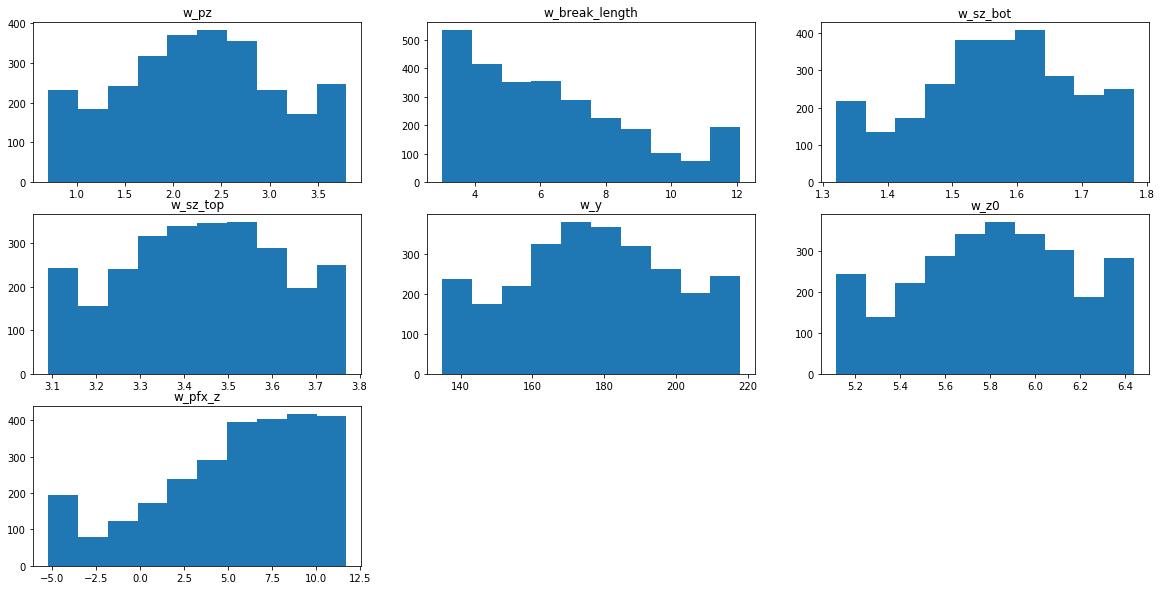

In [13]:
from scipy.stats.mstats import winsorize

plt.figure(figsize=(20,10))
grid = 1

for var in check:
    pitch_sample['w_' + var] = winsorize(pitch_sample[var],(0.05, 0.05))
    
    plt.subplot(3,3,grid)
    plt.hist(pitch_sample['w_' + var])
    plt.title('w_' + var)
    grid+=1
    
    print("For: " + var)
    q75, q25 = np.percentile(pitch_sample['w_' + var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitch_sample['w_' + var] > max_val) | (pitch_sample['w_' + var] < min_val))[0])
    otl_perc = ol/pitch_sample.shape[0]
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))
    
    pitch_sample = pitch_sample.drop(var, 1)

In [14]:
y = pitch_sample['zone']
X = pitch_sample.drop(['zone'],1)
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

Number of mislabeled points out of 2731: 547
Accuracy Rate: 0.7997070670084219


array([[ 69,   4,   0,   8,   2,   0,   0,   0,   0,  10,   0,   0,   0],
       [  1,  64,   2,   1,  13,   1,   0,   0,   0,   4,   0,   0,   0],
       [  0,   3,  53,   0,   0,  12,   0,   0,   0,   0,   7,   0,   3],
       [  6,   2,   0, 102,   6,   0,  10,   0,   0,   1,   0,   4,   0],
       [  1,  25,   0,   7, 117,   3,   0,  14,   0,   0,   0,   0,   0],
       [  0,   1,  12,   0,   5, 108,   0,   0,  10,   0,   0,   0,   2],
       [  0,   0,   0,  12,   0,   0, 102,   6,   0,   0,   1,   8,   0],
       [  0,   1,   0,   0,   4,   1,   7, 112,   2,   1,   0,   0,   2],
       [  0,   0,   0,   0,   0,  12,   0,   2, 105,   0,   0,   0,   7],
       [ 15,   7,   0,   7,   1,   0,   0,   0,   0, 305,   8,  29,   0],
       [  0,  15,   9,   0,   0,   2,   0,   0,   1,   5, 183,   0,  27],
       [  1,   0,   0,   4,   0,   0,  24,  12,   0,  30,   0, 360,   7],
       [  0,   0,   0,   0,   0,   7,   0,  14,  28,   0,  43,   5, 504]])

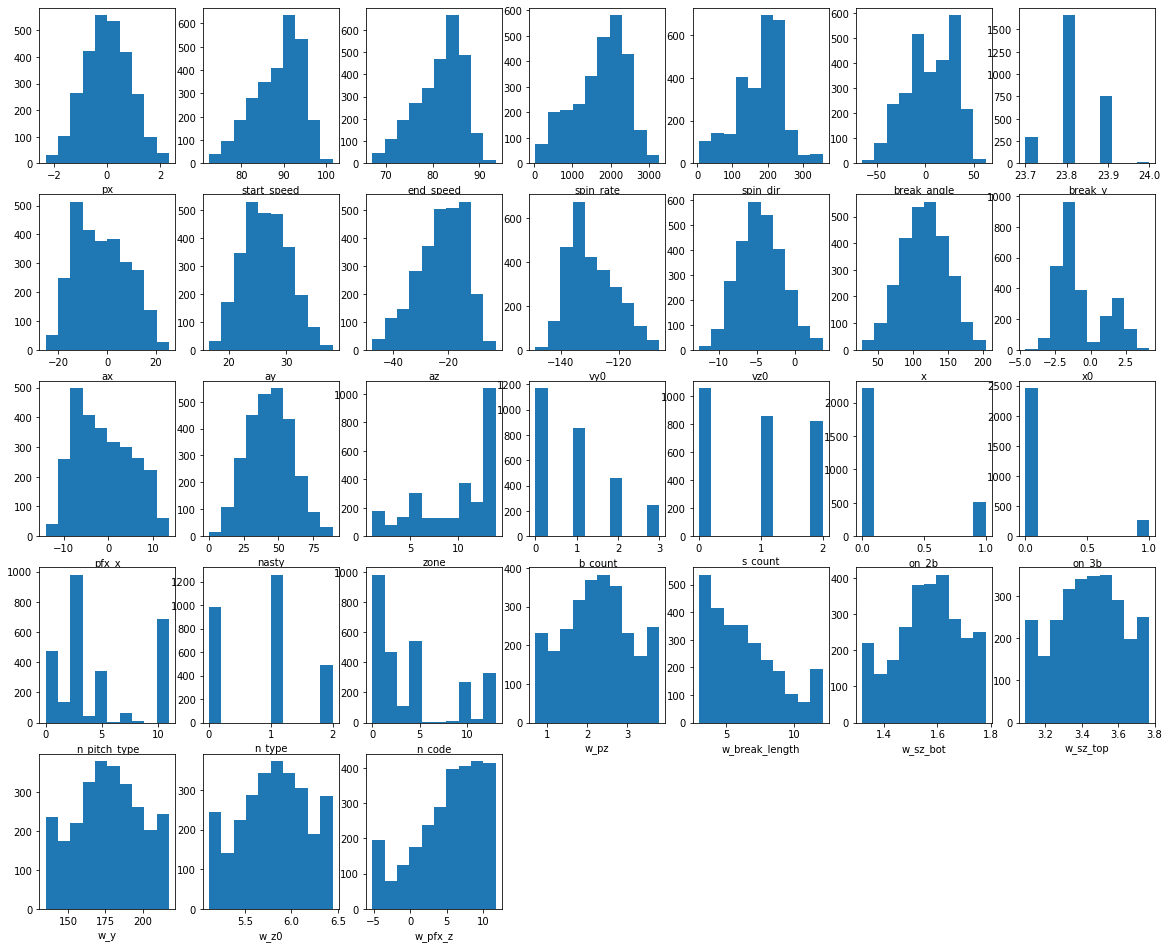

In [15]:
# Let's check our distributions
plt.figure(figsize=(20,20))
grid = 1

for var in list(pitch_sample.columns):
    
    plt.subplot(6,7,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1

In [16]:
# Select columns that look non-normal and get information
lt = ['start_speed', 'end_speed', 'spin_rate', 'w_break_length', 'az', 'vy0', 'x0', 'pfx_x', 'w_pfx_z']
pitch_sample[lt].describe()

,start_speed,end_speed,spin_rate,w_break_length,az,vy0,x0,pfx_x,w_pfx_z
count,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,88.612450,81.595203,1734.586549,6.348517,-22.528323,-129.200698,-0.743170,-1.077333,5.276524
std,5.663756,5.051785,679.662398,2.527877,8.688472,8.220442,1.692230,6.267883,4.656391
min,72.300000,67.100000,31.021000,3.000000,-47.490000,-148.725000,-4.638632,-14.068555,-5.219297
25%,84.500000,78.100000,1257.108000,4.300000,-28.245535,-135.569298,-1.967849,-6.430000,2.463962
50%,89.900000,82.600000,1870.736000,5.900000,-21.560518,-130.944081,-1.336000,-1.863184,6.083330
75%,92.900000,85.350000,2251.500500,7.900000,-15.733000,-123.388711,0.703473,3.825000,9.002314
max,101.500000,93.500000,3272.452000,12.100000,-2.846000,-106.035000,4.165000,13.600000,11.727095


In [17]:
pitch_sample['az_shift'] = pitch_sample['az'] + 48.49
pitch_sample['vy0_shift'] = pitch_sample['vy0'] + 149.725
pitch_sample['x0_shift'] = pitch_sample['x0'] + 5.638632
pitch_sample['pfx_x_shift'] = pitch_sample['pfx_x'] + 15.068555
pitch_sample['w_pfx_z_shift'] = pitch_sample['w_pfx_z'] + 6.219297
pitch_sample = pitch_sample.drop(['az', 'vy0', 'x0', 'pfx_x', 'w_pfx_z'],1)

lt = ['start_speed', 'end_speed', 'spin_rate', 'w_break_length', 'az_shift', 'vy0_shift', 'x0_shift',
      'pfx_x_shift', 'w_pfx_z_shift']
pitch_sample[lt].describe()

,start_speed,end_speed,spin_rate,w_break_length,az_shift,vy0_shift,x0_shift,pfx_x_shift,w_pfx_z_shift
count,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,88.612450,81.595203,1734.586549,6.348517,25.961677,20.524302,4.895462,13.991222,11.495821
std,5.663756,5.051785,679.662398,2.527877,8.688472,8.220442,1.692230,6.267883,4.656391
min,72.300000,67.100000,31.021000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,84.500000,78.100000,1257.108000,4.300000,20.244465,14.155702,3.670783,8.638555,8.683259
50%,89.900000,82.600000,1870.736000,5.900000,26.929482,18.780919,4.302632,13.205371,12.302627
75%,92.900000,85.350000,2251.500500,7.900000,32.757000,26.336289,6.342105,18.893555,15.221611
max,101.500000,93.500000,3272.452000,12.100000,45.644000,43.690000,9.803632,28.668555,17.946392


start_speed
Jarque-Bera test statistics is 178.88782850433768 and p value is 0.0
Normality test statistics is 163.16705797934873 and p value is 3.704448364211242e-36
For: lt_start_speed
Jarque-Bera test statistics is 215.67544451941865 and p value is 0.0
Normality test statistics is 182.24248075342092 and p value is 2.6702266142229857e-40
For: bc_start_speed
Jarque-Bera test statistics is 107.02814949258193 and p value is 0.0
Normality test statistics is 159.64138712331078 and p value is 2.1593012913428924e-35
end_speed
Jarque-Bera test statistics is 202.21276018798892 and p value is 0.0
Normality test statistics is 172.3888868512451 and p value is 3.6832300867316023e-38
For: lt_end_speed
Jarque-Bera test statistics is 248.0011501126137 and p value is 0.0
Normality test statistics is 201.57720639398914 and p value is 1.6906970419245385e-44
For: bc_end_speed
Jarque-Bera test statistics is 104.82923326602128 and p value is 0.0
Normality test statistics is 131.63702158703705 and p value i

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


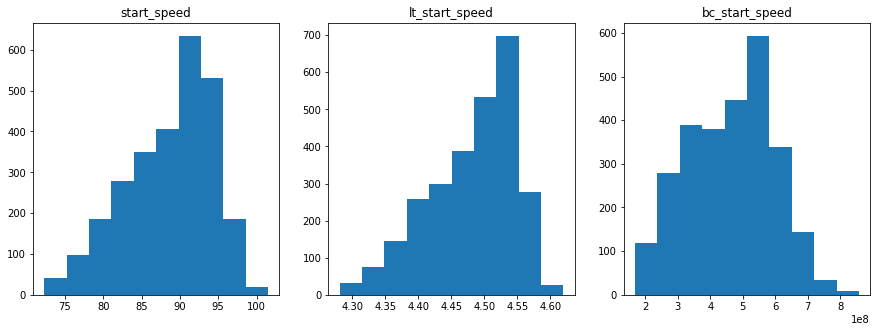

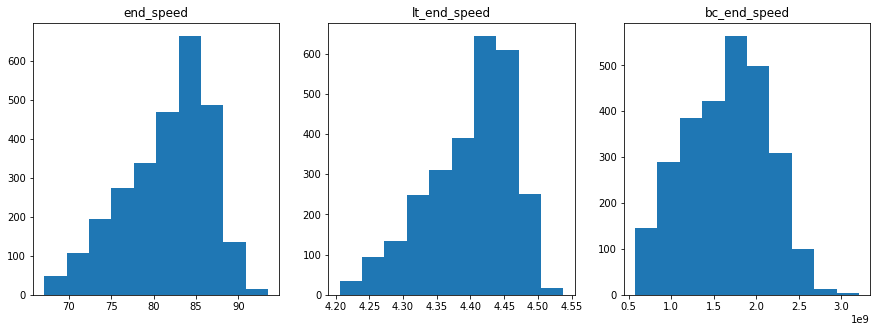

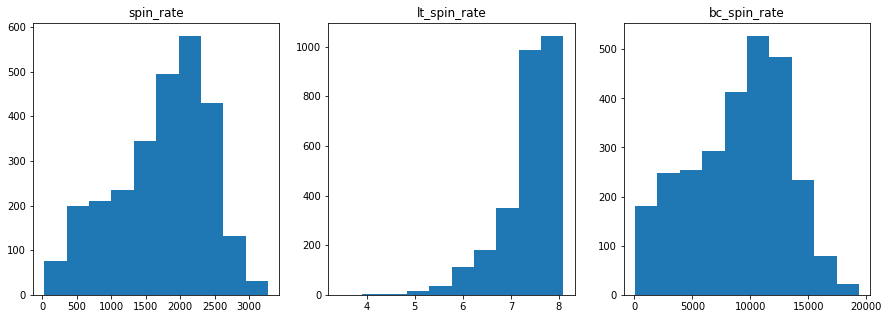

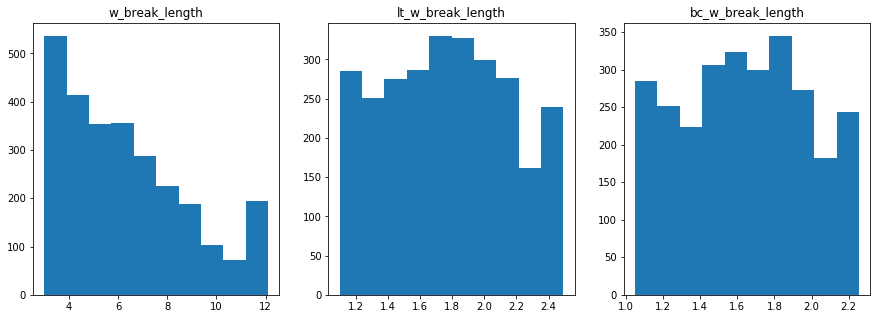

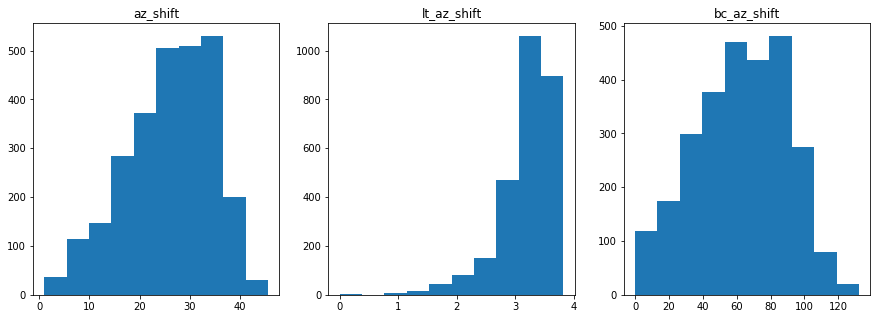

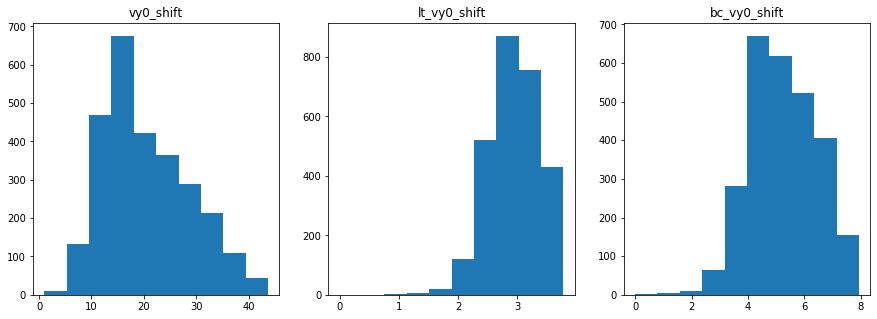

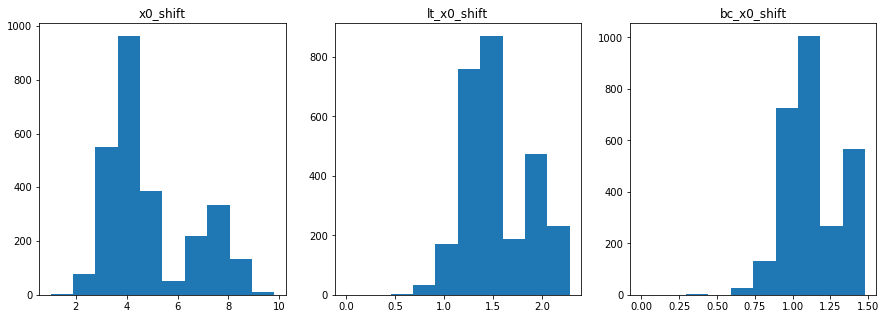

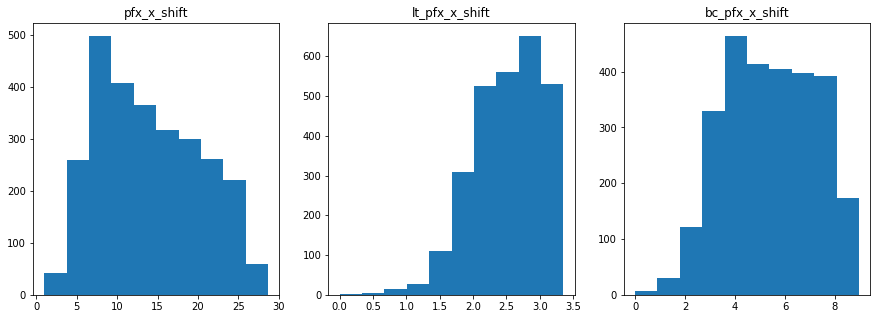

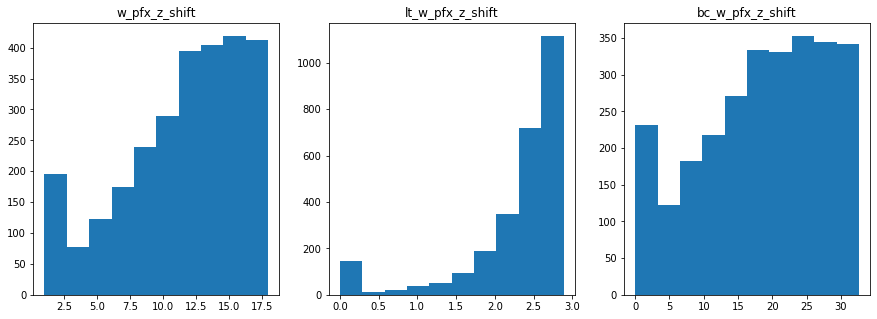

In [18]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox

for var in lt:
    pitch_sample['lt_' + var] = np.log(pitch_sample[var])
    pitch_sample['bc_' + var] = boxcox(pitch_sample[var])[0]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.hist(pitch_sample[var])
    plt.title(var)
    
    plt.subplot(1,3,2)
    plt.hist(pitch_sample['lt_' + var])
    plt.title('lt_' + var) 
    
    plt.subplot(1,3,3)
    plt.hist(pitch_sample['bc_' + var])
    plt.title('bc_' + var)

    print(var)
    jb_stats = jarque_bera(np.sqrt(pitch_sample[var]))
    norm_stats = normaltest(np.sqrt(pitch_sample[var]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    
    print("For: lt_" + var)
    jb_stats = jarque_bera(np.sqrt(pitch_sample['lt_' + var]))
    norm_stats = normaltest(np.sqrt(pitch_sample['lt_' + var]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    
    print("For: bc_" + var)
    jb_stats = jarque_bera(np.sqrt(pitch_sample['bc_' + var]))
    norm_stats = normaltest(np.sqrt(pitch_sample['bc_' + var]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

px                   0.166655
vz0                  0.168766
x                    0.165193
zone                 1.000000
n_type               0.459843
n_code               0.253736
w_pz                 0.411143
w_break_length       0.152609
w_y                  0.380957
lt_w_break_length    0.160317
bc_w_break_length    0.160553
Name: zone, dtype: float64


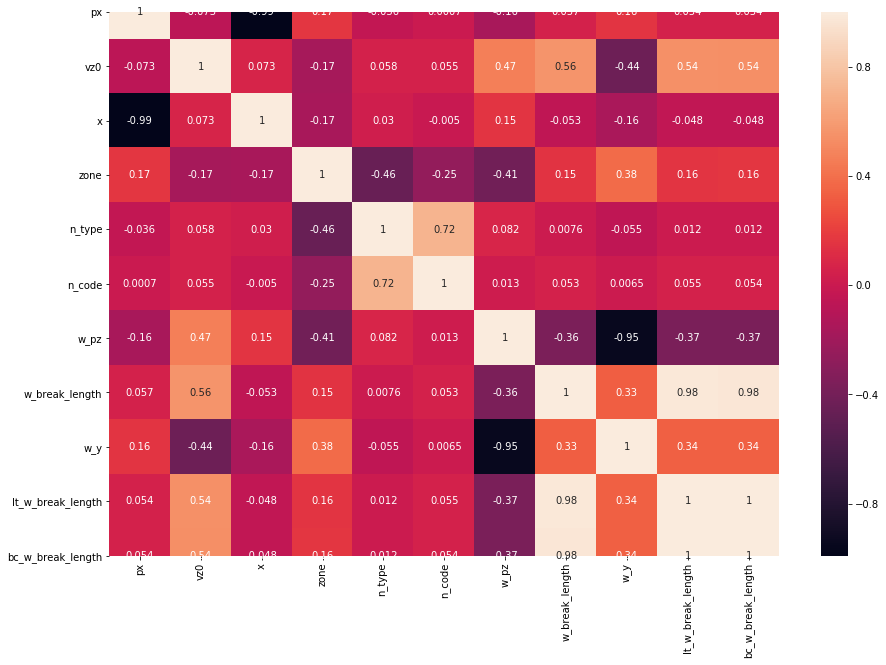

In [19]:
# Identify high correlation features
pcor = pitch_sample.corr()
cor_target = abs(pcor['zone'])
relevant_features = cor_target[cor_target>0.15]
rf_pitch = pitch_sample[list(relevant_features.index)]
print(relevant_features)

# Print Heatmap
plt.figure(figsize=(15,10))
rf_cor = rf_pitch.corr()
sns.heatmap(rf_cor, annot=True)
plt.show()

['px', 'vz0', 'n_type', 'n_code', 'w_pz', 'bc_w_break_length']


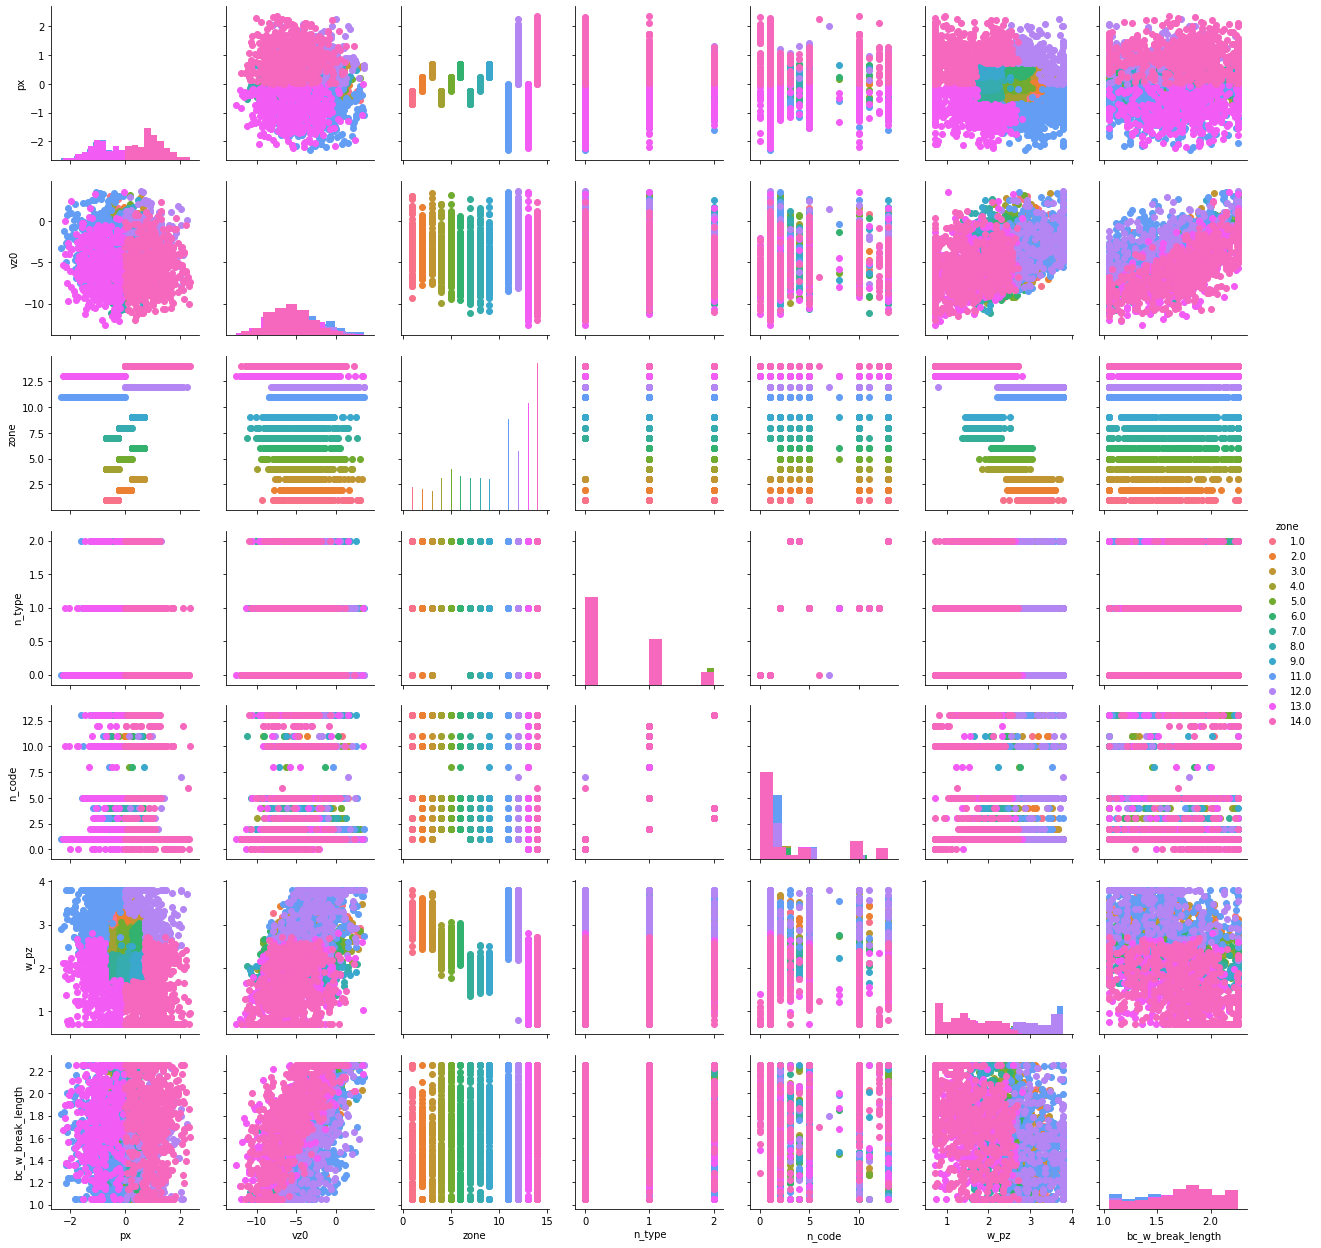

In [20]:
# Drop features with high intercorrelation
rf_pitch = rf_pitch.drop(['x', 'w_y', 'w_break_length', 'lt_w_break_length'], 1)
rel_feat = list(rf_pitch.columns)
rel_feat.remove('zone')
print(rel_feat)

# Visualize multivariate relationships 
g = sns.PairGrid(rf_pitch, hue='zone')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
plt.show()

In [21]:
y = rf_pitch['zone']
X = rf_pitch.drop(['zone'],1)
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)
gnb = GaussianNB()
gnb.fit(X_rs, y_rs)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

# This is the only model that improved slightly with normalization

Number of mislabeled points out of 2731: 492
Accuracy Rate: 0.8198462101794215


array([[ 81,   1,   0,   7,   0,   0,   0,   0,   0,   4,   0,   0,   0],
       [  0,  69,   0,   1,  14,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0,   3,  56,   0,   0,  13,   0,   0,   0,   0,   6,   0,   0],
       [  9,   2,   0, 109,   0,   0,  11,   0,   0,   0,   0,   0,   0],
       [  0,  21,   0,   6, 126,   2,   1,  11,   0,   0,   0,   0,   0],
       [  0,   0,  24,   0,   1, 100,   0,   0,  13,   0,   0,   0,   0],
       [  0,   0,   0,  14,   0,   0, 110,   1,   0,   0,   0,   4,   0],
       [  0,   0,   0,   0,  10,   0,   5, 111,   1,   0,   0,   0,   3],
       [  0,   0,   0,   0,   1,  10,   0,   1, 108,   0,   0,   0,   6],
       [ 32,  11,   0,  12,   1,   0,   0,   0,   0, 305,   0,  11,   0],
       [  0,  15,  16,   0,   0,   7,   0,   0,   1,   4, 193,   0,   6],
       [  0,   0,   0,  10,   0,   0,  31,  13,   0,  17,   0, 367,   0],
       [  0,   0,   0,   0,   0,  17,   0,  17,  42,   0,  21,   0, 504]])

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

nbrs = KNeighborsClassifier(n_neighbors=10, weights='distance')
X = rf_pitch[['px', 'n_type', 'w_pz']]
y = rf_pitch['zone']

X_rs, y_rs = ros.fit_resample(X, y)
# Replace with cross_val_score
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(X_rs, y_rs, test_size=0.25, random_state=400)
nbrs.fit(Xrs_train, yrs_train)

yrs_pred = nbrs.predict(Xrs_test)
print('Test Set Accuracy: {}'.format(metrics.accuracy_score(yrs_test, yrs_pred)))

Test Set Accuracy: 0.9754350051177073


[0.86380832 0.85897436 0.85769231 0.87435897 0.85384615 0.86153846
 0.87820513 0.87435897 0.84615385 0.9       ]


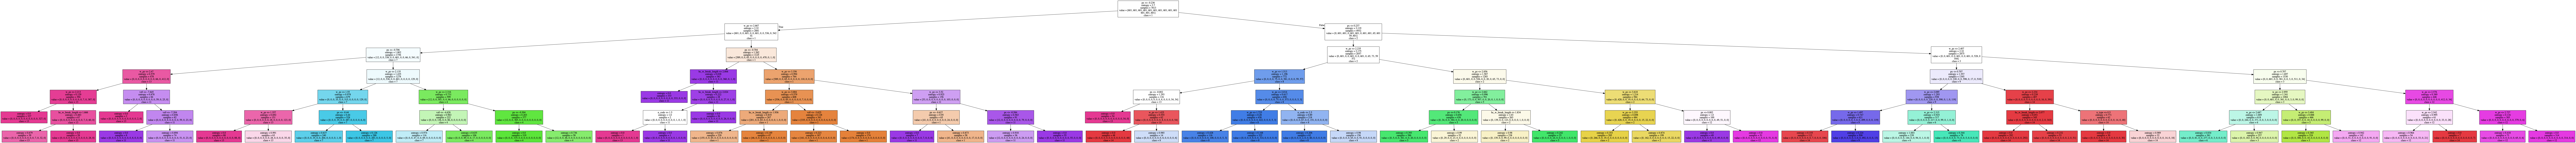

In [23]:
# Decision tree model
from sklearn import tree
from IPython.display import Image
import pydotplus, graphviz
from sklearn.model_selection import cross_val_score

# Reset features and target
X = rf_pitch.drop('zone', 1)
y = rf_pitch['zone']
X_rs, y_rs = ros.fit_resample(X,y)

# Using a simple decision tree to determine fastball or offspeed
pitch_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=6,
)
pitch_tree.fit(X_rs, y_rs)

dot_data = tree.export_graphviz(
    pitch_tree, out_file=None,
    feature_names=X.columns,
    class_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
print(cross_val_score(pitch_tree, X_rs, y_rs, cv=10))
Image(graph.create_png())
# Tree is far less accurate than simple NB

In [24]:
# Forest to predict fastball or offspeed
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_rs, y_rs, cv=10)
# Forest appears to be most accurate model

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/a

array([0.97099622, 0.98076923, 0.98333333, 0.98461538, 0.97692308,
       0.97435897, 0.98589744, 0.98717949, 0.99230769, 0.99358974])

In [25]:
# Finally, let's try a boosting model
params = {'n_estimators': 700,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Xrs_train, yrs_train)
predict_train = clf.predict(Xrs_train)
predict_test = clf.predict(Xrs_test)

# Accuracy tables.
table_train = pd.crosstab(yrs_train, predict_train, margins=True)
table_test = pd.crosstab(yrs_test, predict_test, margins=True)

print(table_train)
print('Training Set Accuracy: {}'.format(metrics.accuracy_score(yrs_train, predict_train)))

print(table_test)
print('Test Set Accuracy: {}'.format(metrics.accuracy_score(yrs_test, predict_test)))

col_0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  11.0  12.0  13.0  14.0  \
row_0                                                                        
1.0    456    0    0    0    0    0    0    0    0     0     0     0     0   
2.0      0  448    0    0    0    0    0    0    0     0     0     0     0   
3.0      0    0  448    0    0    0    0    0    0     0     0     0     0   
4.0      0    0    0  445    0    0    0    0    0     0     0     0     0   
5.0      0    0    0    0  456    0    0    0    0     0     0     0     0   
6.0      0    0    0    0    0  444    0    0    0     0     0     0     0   
7.0      0    0    0    0    0    0  457    0    0     0     0     0     0   
8.0      0    0    0    0    0    0    0  446    0     0     0     0     0   
9.0      0    0    0    0    0    0    0    0  468     0     0     0     0   
11.0     0    0    0    0    0    0    0    0    0   451     0     0     0   
12.0     0    0    0    0    0    0    0    0    0     0   456  